# Training With DimeNet

This notebook gives an example of how to build and train DimeNet. DimeNet uses both atom distances and angles to generate a more powerful molecular representation than SchNet, though at higher computational cost.

First we import dependencies for the tutorial:

In [1]:
import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../..")

from pathlib import Path

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader

from nff.data import Dataset, split_train_validation_test, collate_dicts, to_tensor
from nff.train import Trainer, get_trainer, get_model, load_model, loss, hooks, metrics, evaluate

To instantiate the model, we need to specify:

- `n_rbf`: number of radial basis functions
- `cutoff`: neighbor list cutoff
- `envelope_p`: exponent in the envelope function
- `n_spher`: maximum `n` value for the spherical basis functions
- `l_spher`: maximum `l` value for the spherical basis functions
- `embed_dim`: embedding dimension for the atomic numbers
- `n_bilinear`: dimension of the vector into which we transform the angles in the spherical basis
- `activation`: name of non-linear activation function
- `n_convolutions`: number of convolutions (or interaction blocks)
- `output_keys`: names of the values we want our model to predict
- `grad_keys`: names of the gradients we want out model to take

Note that instantiating the model takes around 10 seconds. This is mainly because the spherical Bessel functions and spherical harmonics need to be translated from `scipy` into `lambda` expresasions with analytical gradients in PyTorch.

In [2]:
modelparams = {"n_rbf": 6,
               "cutoff": 5.0,
               "envelope_p": 5,
               "n_spher": 6,
               "l_spher": 7,
               "embed_dim": 128,
               "n_bilinear": 8,
               "activation": "swish",
               "n_convolutions": 6,
               "output_keys": ["energy"],
               "grad_keys": ["energy_grad"]}

model = get_model(modelparams, model_type="DimeNet")


Next we make a directory for our work and load the ethanol dataset:

In [3]:
DEVICE = 0
OUTDIR = './sandbox'
BATCH_SIZE = 40

if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)
        
    shutil.move(OUTDIR, newpath)
    
dataset = Dataset.from_file('./data/dataset.pth.tar')

Because DimeNet uses angles as well as distances, we need to generate an angle list in addition to a neighbor list:

In [4]:
angles = dataset.generate_angle_list()
angles[0]

100%|██████████| 1000/1000 [00:01<00:00, 691.14it/s]


tensor([[0, 1, 2],
        [0, 1, 3],
        [0, 1, 4],
        ...,
        [8, 7, 4],
        [8, 7, 5],
        [8, 7, 6]])

Next we make the training splits, loaders, and trainer:

In [5]:
train, val, test = split_train_validation_test(dataset, val_size=0.2, test_size=0.2)

train_loader = DataLoader(train, batch_size=BATCH_SIZE, collate_fn=collate_dicts)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, collate_fn=collate_dicts)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_dicts)

loss_fn = loss.build_mse_loss(loss_coef={'energy': 0.1, 'energy_grad': 1})
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=3e-4)

train_metrics = [
    metrics.MeanAbsoluteError('energy'),
    metrics.MeanAbsoluteError('energy_grad')
]


train_hooks = [
    hooks.MaxEpochHook(100),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | ',
        time_strf='%M:%S'
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]

T = Trainer(
    model_path=OUTDIR,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
    checkpoint_interval=1,
    hooks=train_hooks
)

Now we train and see the results!

In [6]:
T.train(device=DEVICE, n_epochs=100)

 Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy | MAE_energy_grad | GPU Memory (MB)


 93%|█████████▎| 14/15 [00:03<00:00,  3.83it/s]


30:49 |     1 |     3.000e-04 |   668.5738 |        373.5742 |     5.1977 |         13.3849 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.97it/s]


30:53 |     2 |     3.000e-04 |   233.3884 |        116.5383 |     3.7764 |          7.5834 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.96it/s]


30:57 |     3 |     3.000e-04 |    70.1614 |         39.1093 |     1.4070 |          4.4010 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.90it/s]


31:01 |     4 |     3.000e-04 |    27.6672 |         20.8772 |     2.1127 |          3.2034 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.88it/s]


31:05 |     5 |     3.000e-04 |    16.5135 |         13.1223 |     1.1542 |          2.5665 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.95it/s]


31:09 |     6 |     3.000e-04 |    11.8392 |         10.2562 |     1.1589 |          2.2682 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.91it/s]


31:13 |     7 |     3.000e-04 |     9.4714 |         10.0736 |     1.9165 |          2.1806 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.96it/s]


31:17 |     8 |     3.000e-04 |     7.8026 |          7.2678 |     1.0785 |          1.8665 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.97it/s]


31:21 |     9 |     3.000e-04 |     6.7335 |          6.1205 |     0.7442 |          1.7190 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.90it/s]


31:26 |    10 |     3.000e-04 |     6.3137 |          6.9000 |     2.7710 |          1.7331 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.91it/s]


31:30 |    11 |     3.000e-04 |     5.5671 |          6.3843 |     2.9194 |          1.6618 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.04it/s]


31:33 |    12 |     3.000e-04 |     4.8291 |          5.7764 |     2.6299 |          1.5941 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.39it/s]


31:37 |    13 |     3.000e-04 |     4.6295 |          6.1155 |     3.1748 |          1.6052 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.40it/s]


31:41 |    14 |     3.000e-04 |     4.7483 |          6.9958 |     4.0026 |          1.6590 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.37it/s]


31:44 |    15 |     3.000e-04 |     4.9184 |          4.4656 |     2.2757 |          1.4226 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.92it/s]


31:49 |    16 |     3.000e-04 |     4.2866 |          4.0606 |     2.1508 |          1.3245 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.32it/s]


31:52 |    17 |     3.000e-04 |     3.4454 |          3.9697 |     2.0961 |          1.3156 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.40it/s]


31:56 |    18 |     3.000e-04 |     3.4045 |          3.3119 |     0.4383 |          1.3012 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.24it/s]


32:00 |    19 |     3.000e-04 |     3.3669 |          3.3070 |     0.3713 |          1.2821 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.35it/s]


32:04 |    20 |     3.000e-04 |     3.2747 |          3.8547 |     2.1507 |          1.3327 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.04it/s]


32:07 |    21 |     3.000e-04 |     3.2811 |          5.0367 |     3.7326 |          1.4035 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.26it/s]


32:11 |    22 |     3.000e-04 |     3.1170 |          4.6446 |     3.0125 |          1.3764 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.26it/s]


32:15 |    23 |     3.000e-04 |     3.1024 |          5.2961 |     2.4344 |          1.5278 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.19it/s]


32:19 |    24 |     3.000e-04 |     3.1789 |          3.1266 |     0.3024 |          1.3116 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.39it/s]


32:22 |    25 |     3.000e-04 |     3.8279 |          4.0356 |     2.4667 |          1.2738 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.99it/s]


32:26 |    26 |     3.000e-04 |     2.3814 |          2.6985 |     0.8801 |          1.1883 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.41it/s]


32:30 |    27 |     3.000e-04 |     3.2272 |          2.6138 |     1.6250 |          1.0794 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.36it/s]


32:34 |    28 |     3.000e-04 |     3.1406 |          4.2018 |     1.5740 |          1.5372 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.41it/s]


32:37 |    29 |     3.000e-04 |     3.9006 |          5.4476 |     0.7436 |          1.7172 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.04it/s]


32:41 |    30 |     3.000e-04 |     3.3010 |          3.1218 |     2.8383 |          1.0485 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.41it/s]


32:45 |    31 |     3.000e-04 |     2.2963 |          2.2804 |     0.7480 |          1.0720 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.95it/s]


32:49 |    32 |     3.000e-04 |     1.6610 |          1.9019 |     0.3121 |          0.9770 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.10it/s]


32:53 |    33 |     3.000e-04 |     1.4704 |          2.2952 |     0.8990 |          1.0966 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.42it/s]


32:56 |    34 |     3.000e-04 |     1.5445 |          2.4681 |     0.6610 |          1.1656 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.21it/s]


33:00 |    35 |     3.000e-04 |     1.5860 |          2.3675 |     0.3644 |          1.1545 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.39it/s]


33:04 |    36 |     3.000e-04 |     1.5206 |          2.4521 |     0.5920 |          1.1787 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.31it/s]


33:07 |    37 |     3.000e-04 |     1.5222 |          2.5114 |     0.6088 |          1.1969 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.98it/s]


33:11 |    38 |     3.000e-04 |     1.5212 |          2.4912 |     0.7382 |          1.1878 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.13it/s]


33:15 |    39 |     3.000e-04 |     1.5220 |          2.5322 |     0.9765 |          1.1906 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.87it/s]


33:19 |    40 |     3.000e-04 |     1.5335 |          2.5608 |     1.2324 |          1.1852 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.28it/s]


33:23 |    41 |     3.000e-04 |     1.5518 |          2.5246 |     1.5632 |          1.1503 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.42it/s]


33:27 |    42 |     3.000e-04 |     1.5750 |          2.2927 |     1.7751 |          1.0551 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.10it/s]


33:30 |    43 |     3.000e-04 |     1.5913 |          1.8264 |     1.5733 |          0.9086 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.00it/s]


33:35 |    44 |     3.000e-04 |     1.5775 |          1.5458 |     0.9360 |          0.8407 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.92it/s]


33:39 |    45 |     3.000e-04 |     1.4838 |          1.6547 |     0.4246 |          0.8928 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.87it/s]


33:43 |    46 |     3.000e-04 |     1.3146 |          1.6184 |     0.5185 |          0.8840 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.94it/s]


33:47 |    47 |     3.000e-04 |     1.1706 |          1.5169 |     0.8171 |          0.8478 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.90it/s]


33:51 |    48 |     3.000e-04 |     1.0608 |          1.4040 |     0.6983 |          0.8241 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.87it/s]


33:55 |    49 |     3.000e-04 |     1.0025 |          1.3188 |     0.4714 |          0.8050 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.93it/s]


33:59 |    50 |     3.000e-04 |     1.0623 |          1.2560 |     0.1934 |          0.7902 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.05it/s]


34:03 |    51 |     3.000e-04 |     1.1340 |          1.3536 |     0.9566 |          0.7890 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.98it/s]


34:07 |    52 |     3.000e-04 |     1.2102 |          2.0922 |     2.6885 |          0.8162 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.88it/s]


34:11 |    53 |     3.000e-04 |     1.0706 |          1.2101 |     0.1889 |          0.7699 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.96it/s]


34:15 |    54 |     3.000e-04 |     0.8549 |          1.1840 |     0.2890 |          0.7592 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.89it/s]


34:19 |    55 |     3.000e-04 |     0.8495 |          1.2277 |     0.8910 |          0.7500 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.87it/s]


34:24 |    56 |     3.000e-04 |     1.3312 |          1.8748 |     2.4074 |          0.7925 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.87it/s]


34:28 |    57 |     3.000e-04 |     1.0477 |          1.1191 |     0.1854 |          0.7361 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.85it/s]


34:32 |    58 |     3.000e-04 |     0.7933 |          1.2426 |     0.8752 |          0.7598 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.38it/s]


34:35 |    59 |     3.000e-04 |     0.7699 |          1.0661 |     0.2825 |          0.7154 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.29it/s]


34:39 |    60 |     3.000e-04 |     0.7466 |          1.0819 |     0.4005 |          0.7268 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.30it/s]


34:43 |    61 |     3.000e-04 |     1.6269 |          2.2985 |     3.2067 |          0.7838 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.33it/s]


34:46 |    62 |     3.000e-04 |     1.3152 |          1.3471 |     0.9847 |          0.7660 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.30it/s]


34:50 |    63 |     3.000e-04 |     1.0066 |          1.2734 |     0.6592 |          0.7797 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.32it/s]


34:54 |    64 |     3.000e-04 |     0.8427 |          1.1158 |     0.5716 |          0.7304 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.28it/s]


34:57 |    65 |     3.000e-04 |     0.8052 |          1.0548 |     0.1735 |          0.7146 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.35it/s]


35:01 |    66 |     3.000e-04 |     0.8220 |          1.1418 |     0.5195 |          0.7315 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.31it/s]


35:05 |    67 |     3.000e-04 |     1.0264 |          1.4302 |     0.3383 |          0.8404 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.36it/s]


35:08 |    68 |     3.000e-04 |     1.4997 |          3.6598 |     0.4240 |          1.4362 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.33it/s]


35:12 |    69 |     3.000e-04 |     2.7534 |          3.7428 |     2.8723 |          1.2742 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.31it/s]


35:16 |    70 |     3.000e-04 |     2.3866 |          1.5408 |     0.2801 |          0.8475 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.35it/s]


35:19 |    71 |     3.000e-04 |     0.9635 |          1.1497 |     0.8829 |          0.7254 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.35it/s]


35:23 |    72 |     3.000e-04 |     0.8469 |          1.1864 |     0.6770 |          0.7574 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.04it/s]


35:27 |    73 |     3.000e-04 |     0.8759 |          1.1102 |     0.6674 |          0.7254 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.06it/s]


35:31 |    74 |     3.000e-04 |     0.8924 |          1.1239 |     0.7799 |          0.7260 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.93it/s]


35:35 |    75 |     3.000e-04 |     0.8896 |          1.2128 |     1.0426 |          0.7505 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.02it/s]


35:39 |    76 |     3.000e-04 |     0.9322 |          1.3608 |     1.0934 |          0.8100 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.06it/s]


35:43 |    77 |     3.000e-04 |     1.0270 |          1.6431 |     1.3543 |          0.9002 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.99it/s]


35:47 |    78 |     3.000e-04 |     1.1482 |          2.2014 |     1.9314 |          1.0324 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.97it/s]


35:51 |    79 |     3.000e-04 |     1.3345 |          2.6282 |     2.1453 |          1.1319 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.03it/s]


35:55 |    80 |     3.000e-04 |     1.5079 |          1.4214 |     0.6648 |          0.8593 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.01it/s]


35:59 |    81 |     3.000e-04 |     1.4889 |          1.9170 |     2.5095 |          0.7954 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.98it/s]


36:03 |    82 |     3.000e-04 |     1.2286 |          0.9941 |     0.6703 |          0.6840 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.01it/s]


36:07 |    83 |     3.000e-04 |     0.7470 |          1.1940 |     1.2904 |          0.7405 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.99it/s]


36:11 |    84 |     3.000e-04 |     1.0550 |          1.0713 |     0.6591 |          0.7048 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.92it/s]


36:15 |    85 |     3.000e-04 |     0.7687 |          0.9963 |     0.9461 |          0.6713 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.93it/s]


36:19 |    86 |     3.000e-04 |     0.9053 |          1.5309 |     1.6411 |          0.8138 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.03it/s]


36:23 |    87 |     3.000e-04 |     0.9265 |          1.3247 |     0.1802 |          0.8282 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.94it/s]


36:27 |    88 |     3.000e-04 |     1.1309 |          1.8340 |     0.2396 |          0.9485 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.96it/s]


36:31 |    89 |     3.000e-04 |     1.0861 |          1.9681 |     0.2301 |          1.0070 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.08it/s]


36:35 |    90 |     3.000e-04 |     1.2282 |          1.3764 |     0.2843 |          0.8343 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.88it/s]


36:39 |    91 |     3.000e-04 |     1.3179 |          1.0125 |     0.1556 |          0.7117 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.90it/s]


36:43 |    92 |     3.000e-04 |     1.2359 |          1.4708 |     0.6211 |          0.8400 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.92it/s]


36:47 |    93 |     3.000e-04 |     0.8928 |          1.3799 |     1.1784 |          0.8081 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.91it/s]


36:51 |    94 |     3.000e-04 |     0.7971 |          1.1578 |     1.3705 |          0.6997 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.97it/s]


36:55 |    95 |     3.000e-04 |     0.7508 |          0.8093 |     0.1984 |          0.6160 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.05it/s]


36:59 |    96 |     3.000e-04 |     0.6041 |          0.8381 |     0.8544 |          0.6067 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.97it/s]


37:03 |    97 |     3.000e-04 |     0.5445 |          0.7962 |     0.6242 |          0.6055 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.93it/s]


37:07 |    98 |     3.000e-04 |     0.5280 |          0.7636 |     0.1859 |          0.6053 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  4.03it/s]


37:11 |    99 |     3.000e-04 |     0.4678 |          0.8111 |     0.4456 |          0.6162 |            2588


 93%|█████████▎| 14/15 [00:03<00:00,  3.98it/s]


37:15 |   100 |     3.000e-04 |     1.1576 |          0.8816 |     0.2881 |          0.6498 |            2588


We pick the model that got the best validation score and evaluate it on the test set:

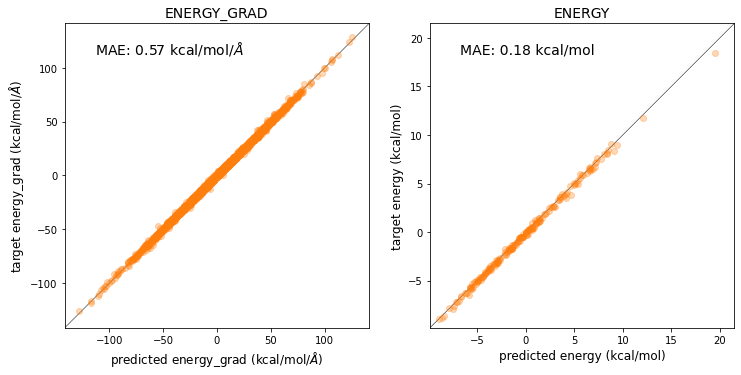

In [7]:
results, targets, val_loss = evaluate(T.get_best_model(), test_loader, loss_fn, device=DEVICE)


units = {
    'energy_grad': r'kcal/mol/$\AA$',
    'energy': 'kcal/mol'
}

fig, ax_fig = plt.subplots(1, 2, figsize=(12, 6))

for ax, key in zip(ax_fig, units.keys()):
    pred = torch.stack(results[key], dim=0).view(-1).detach().cpu().numpy()
    targ = torch.stack(targets[key], dim=0).view(-1).detach().cpu().numpy()
    mae = abs(pred-targ).mean()
    
    ax.scatter(pred, targ, color='#ff7f0e', alpha=0.3)
    
    lim_min = min(np.min(pred), np.min(targ)) * 1.1
    lim_max = max(np.max(pred), np.max(targ)) * 1.1
    
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    ax.set_aspect('equal')
    
    ax.plot((lim_min, lim_max),
            (lim_min, lim_max),
            color='#000000',
            zorder=-1,
            linewidth=0.5)
    
    ax.set_title(key.upper(), fontsize=14)
    ax.set_xlabel('predicted %s (%s)' % (key, units[key]), fontsize=12)
    ax.set_ylabel('target %s (%s)' % (key, units[key]), fontsize=12)
    ax.text(0.1, 0.9, 'MAE: %.2f %s' % (mae, units[key]), 
           transform=ax.transAxes, fontsize=14)

plt.show()

The force and energy errors are respectively 2.5$\times$ and 3.5$\times$ smaller than the SchNet errors trained on the same data (0.62 vs. 1.55 kcal/mol/A and 0.24 vs. 0.86 kcal/mol)!

# For fun: visualizing the basis functions
We can look at the radial and spherical basis functions to see what they look like. We can build the radial functions ourselves and compare them with and without the polynomial envelope: 

In [8]:
from nff.nn.layers import Envelope

envelope_p = 5
envelope = Envelope(envelope_p)

Layers with and without envelope function:

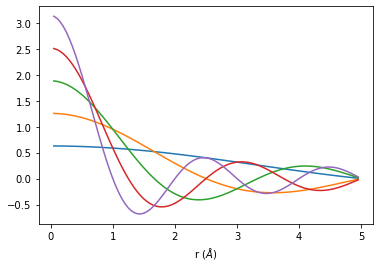

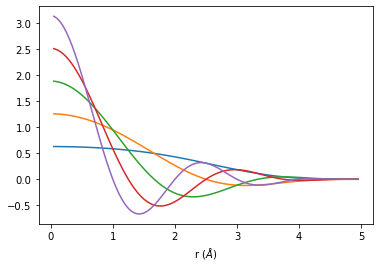

In [9]:
cutoff = 5.0

n_rbf = 5
d = torch.arange(0, cutoff, 0.05).reshape(-1, 1)
n = torch.arange(1, n_rbf + 1).float()
k_n = n * np.pi / cutoff
env = envelope(d / 5)

arg = torch.sin(k_n * d) / d
plt.plot(d, arg)
plt.xlabel("r ($\AA$)")
plt.show()

plt.plot(d, arg *env)
plt.xlabel("r ($\AA$)")

plt.show()

We can also get the layers directly from the module `DimeNetRadialBasis`:

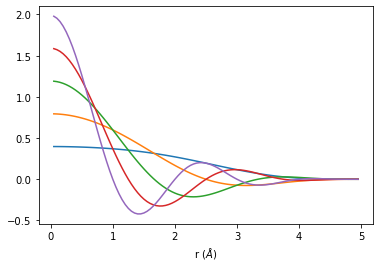

In [10]:
from nff.nn.layers import DimeNetRadialBasis, DimeNetSphericalBasis

dime_rbf = DimeNetRadialBasis(n_rbf=n_rbf,
                 cutoff=cutoff,
                 envelope_p=envelope_p)
out = dime_rbf(d)
plt.plot(d, out.detach().numpy())
plt.xlabel("r ($\AA$)")
plt.show()

Let's take a look at spherical basis functions, which we get from the `DimeNetSphericalBasis` module. First instantiate the module:

In [11]:
n_spher = 4
l_spher = 4
dime_sbf = DimeNetSphericalBasis(l_spher=l_spher,
                 n_spher=n_spher,
                 cutoff=5.0,
                 envelope_p=6)

Then make an x-y grid, calculate the distances and angles at each point on the grid, get the radial and angular parts of the spherical basis functions, and plot their product:

In [12]:
self = dime_sbf

pos_x = torch.arange(0.05, self.cutoff * 1.2, 0.05)
neg_x = torch.arange(-self.cutoff * 1.2, -0.05, 0.05)

x = torch.cat([neg_x, pos_x])
y = torch.cat([neg_x, pos_x])


xv, yv = np.meshgrid(x, y)
xv = torch.Tensor(xv)
yv = torch.Tensor(yv)
                     
angles = torch.atan2(input=xv, other=yv)
d = (xv ** 2 + yv ** 2) ** 0.5

d_scaled = d / self.cutoff
rbf = [f(d_scaled) for f in self.bessel_funcs]
rbf = torch.stack(rbf, dim=1)

u = self.envelope(d_scaled)
cbf = [f(angles) for f in self.sph_funcs]
cbf = torch.stack(cbf, dim=1)


/home/saxelrod/miniconda3/envs/nff/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


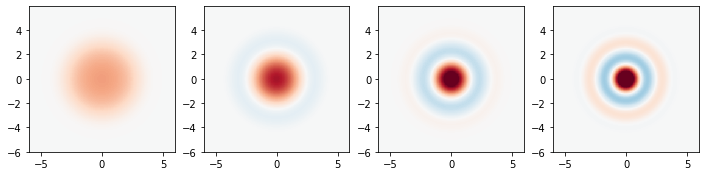

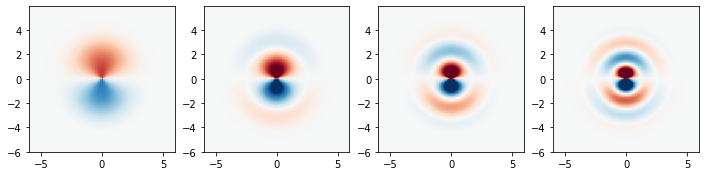

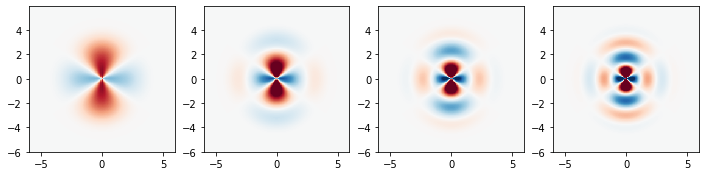

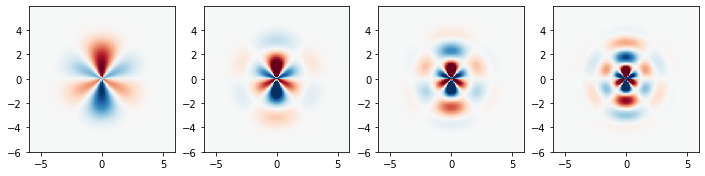

In [13]:
for l in range(l_spher):
    totals = []
    for n in range(n_spher):
        total = cbf[:, l, :] * rbf[:, n, :] * u
        mask = np.heaviside(cutoff - d, 0)
        totals.append(total * mask)
        
    fig, ax_fig = plt.subplots(1, n_spher, figsize=(12, 6))

    
    for i, ax in enumerate(ax_fig):
        z = -totals[i].numpy() 
        mesh = ax.pcolormesh(xv, yv, z, cmap='RdBu',
                            vmin=-3,
                            vmax=3)
        ax.set_aspect(1)
        